In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

## TV ADMM Solver (denoising)

### Solve total variation minimization via ADMM

Solves the following problem via ADMM:

```
   min  (1/2)||x - b||_2^2 + lambda * sum_i |x_{i+1} - x_i|
```

where b in R^n.

The solution is returned in the vector x.

history is a structure that contains the objective value, the primal and
dual residual norms, and the tolerances for the primal and dual residual
norms at each iteration.

rho is the augmented Lagrangian parameter.

alpha is the over-relaxation parameter (typical values for alpha are
between 1.0 and 1.8).

More information can be found in the paper linked at:
http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html

*Code adapted from Steven Boyd*
https://web.stanford.edu/~boyd/papers/admm/total_variation/total_variation.html

In [130]:
from scipy.sparse.linalg import LinearOperator, cg

def matrix_free_tv(b, lam, rho, alpha):
    n = len(b)

    def D(v):
        return v - np.roll(v, -1)

    def mv(v):
        # return v + rho * (2*v - np.roll(v, -1) - np.roll(v, 1))
        # return v + rho * DtD @ v
        return v + rho * Dt(D(v))

    F = LinearOperator((n,n), matvec=mv)

    x = np.zeros((n,))
    z = x.copy()
    u = x.copy()


    for k in range(1000):

        # x-update (minimization)
        # iterative version
        x, _ = cg(F, b + rho * Dt(z - u), maxiter=100, x0 = x)

        # z-update (minimization) with relaxation
        # uses soft thresholding - the proximity operator of the l-1 norm
        z_ = z
        Ax_hat = alpha * D(x) + (1 - alpha) * z_
        z = shrinkage(Ax_hat + u, lam / rho)

        # y-update (dual update)
        u = u + Ax_hat - z


    return x

In [131]:
def D(v):
    return v - np.roll(v, -1)

def Dt(v):
    return v - np.roll(v, 1)

def mv(v):
    return v + Dt(D(v))

v = np.arange(5)
print(v)
print(np.roll(v, -1))
v_ = v - np.roll(v, -1)
print(v_)
print(np.roll(v_, 1))
v__ = v - np.roll(v_, 1)
print(v__)
print(v + v__)
mv(v)

[0 1 2 3 4]
[1 2 3 4 0]
[-1 -1 -1 -1  4]
[ 4 -1 -1 -1 -1]
[-4  2  3  4  5]
[-4  3  5  7  9]


array([-5,  1,  2,  3,  9])

array([0, 1, 2, 3, 4])

In [132]:
# generate some noisy data
n = 2000
noise_level = 0.05

b = np.sin(np.linspace(0, np.pi * 2, n))
for i in range(0, n - n//10, n//5):
    b[range(i, i + n//10)] *= 0
b_ = noise_level * np.random.randn(n) + b

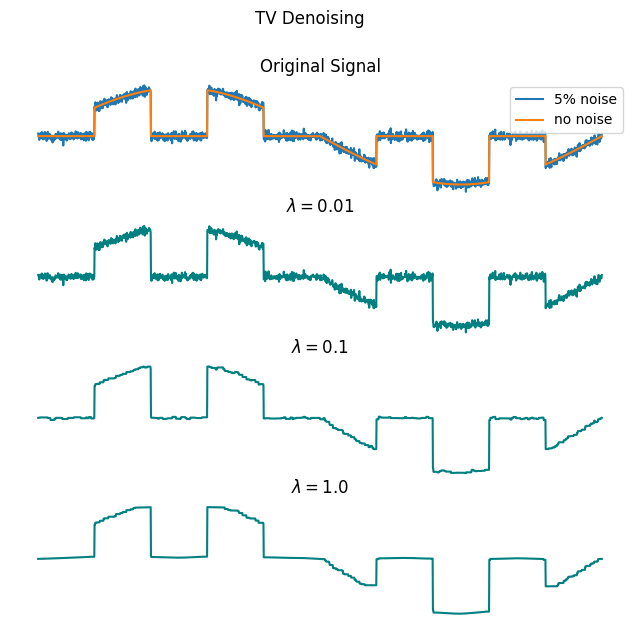

In [133]:
fig, axs = plt.subplots(4, 1, figsize=(8, 7))
fig.suptitle("TV Denoising")
axs[0].plot(b_, label='5% noise')
axs[0].plot(b, label='no noise')
axs[0].legend(loc='upper right', prop={'size': 10})
axs[0].axis('off')
axs[0].set_title('Original Signal', size=12)

for i, lam in enumerate([0.01, 0.1, 1.0]):
    x = matrix_free_tv(b_, lam, 1.0, 1.0)
    axs[i+1].plot(x, 'teal', label=f'$\lambda = {lam}$')
    axs[i+1].set_title(f'$\lambda = {lam}$', size=12)
    axs[i+1].axis('off')

plt.show()

In [119]:
n = 5
e = np.ones(n)
print(e)
# difference matrix
D = scipy.sparse.spdiags(np.vstack((e, -e)), (0, 1), n, n)
DtD = D.T @ D
DtD.todense()
# D.todense()

[1. 1. 1. 1. 1.]


matrix([[ 1., -1.,  0.,  0.,  0.],
        [-1.,  2., -1.,  0.,  0.],
        [ 0., -1.,  2., -1.,  0.],
        [ 0.,  0., -1.,  2., -1.],
        [ 0.,  0.,  0., -1.,  2.]])